In [1]:
%matplotlib inline
from utils import read, createGraph, readGenders, functionals
from glob import iglob as glob
from os.path import exists, basename
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import scipy as sp
import pickle
import warnings
import community
import networkx as nx
import itertools
import scipy as sp 

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
th = 2
data_dir = "./data/by_movie/*"
info_dir = "./data/speakersWithCharacterInfo/"
genre_file = "./data/genres.pickle"

## Read all scripts

In [3]:
genres = pickle.load(open(genre_file, 'rb'))

data = {}
for script in glob(data_dir):
    
    movie, char_list, adj = read(script, threshold = th)

    gender_file = info_dir + basename(script).replace(".", "_") + ".txt"
    if exists(gender_file):
        gens = readGenders(gender_file)
    else:
        gens = defaultdict(lambda: 'unknown')

    G = createGraph(char_list, adj, gens)


    key = basename(script)

    data[key] = {}
    data[key]['graph'] = G
    data[key]['chars'] = char_list
    data[key]['genres'] = genres.get(movie, [])
    
    if isinstance(data[key]['genres'], np.ndarray):
        data[key]['genres'] = list(data[key]['genres'])
    elif isinstance(data[key]['genres'], str):
        data[key]['genres'] = [data[key]['genres']]

In [44]:
types = Counter([y for x in [d['genres'] for script, d in data.items()] for y in x])
print(types)
types = list(types.keys())

Counter({'Drama': 343, 'Thriller': 200, 'Comedy': 188, 'Crime': 147, 'Action': 121, 'Romance': 116, 'Mystery': 83, 'Adventure': 71, 'Sci-Fi': 68, 'Horror': 51, 'Fantasy': 40, 'Biography': 38, 'War': 19, 'History': 19, 'Music': 18, 'Sport': 15, 'Musical': 10, 'Family': 9, 'Animation': 8, 'Western': 8, 'Film-Noir': 5, 'Reality-TV': 1})


In [47]:
# Drop reality TV from genres
types.remove('Reality-TV')

In [48]:
xkcd_colors = sns.xkcd_palette(["grass green", "sand", "blue", "light red", "cerulean",
                                "red", "light blue", "teal", "orange", "light green",
                                "magenta", "yellow", "sky blue", "grey", "cobalt",
                                "grass", "algae green", "coral", "cerise", "steel",
                                "hot purple", "mango", "pale lime", "rouge"])
colors = itertools.cycle(xkcd_colors)

# Pre-check
In [GENDER BIAS WITHOUT BORDERS](http://seejane.org/wp-content/uploads/gender-bias-without-borders-executive-summary.pdf), there is a ratio of 2.25 men for every women on screen (women = $30.9$%). Lets check our numbers.

In [49]:
total, males, females = 0, 0, 0
for _, d in data.items():
    G = d['graph']
    
    for i in G.nodes():
        if G.node[i]['gender'] == 'male':
            males += 1
        elif G.node[i]['gender'] == 'female':
            females += 1
        
        total += 1
        
print("total: {}".format(total))
print("males: {:.2f}%".format(float(males) / total))
print("females: {:.2f}%".format(float(females) / total))


total: 7725
males: 0.51%
females: 0.21%


What if we drop unknown?... shouldn't matter right?

In [50]:
print("males: {:.2f}%".format(float(males) / (males + females)))
print("females: {:.2f}%".format(float(females) / (males + females)))

males: 0.71%
females: 0.29%


# Graph analysis

# Degree centrality

#### Average degree

In [51]:
warnings.simplefilter("ignore")
male_deg, female_deg = [], []
for script, d in data.items():
    G = d['graph']
    degrees = nx.degree(G)
    
    male_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

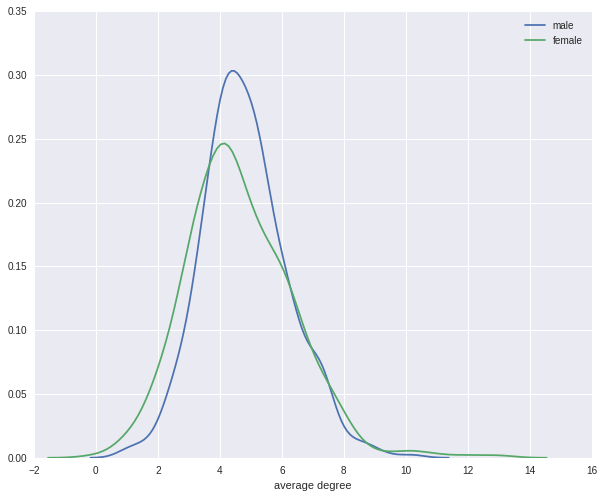

In [52]:
sns.distplot(male_deg, hist = False, label = "male");
sns.distplot(female_deg, hist = False, label = "female");
plt.legend();
plt.xlabel("average degree");

There is no real difference in the number of connections between men and women.

In [53]:
#Remove nans
male_deg, female_deg = np.array(male_deg), np.array(female_deg)
male_deg = male_deg[~np.isnan(male_deg)]
female_deg = female_deg[~np.isnan(female_deg)]


sp.stats.ttest_ind(male_deg, female_deg)

Ttest_indResult(statistic=1.6892810735015003, pvalue=0.091503304822098508)

### Based on Genre

In [54]:
res = {}
for t in types:
    male_deg, female_deg = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        degrees = nx.degree(G)

        male_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
        female_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))
    
    res[t] = {}
    res[t]['male'] = male_deg
    res[t]['female'] = female_deg

In [55]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "value"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

tmp.head()

,genre,gender,value
0,Mystery,female,3.000000
1,Mystery,female,4.333333
2,Mystery,female,NaN
3,Mystery,female,4.500000
4,Mystery,female,4.600000


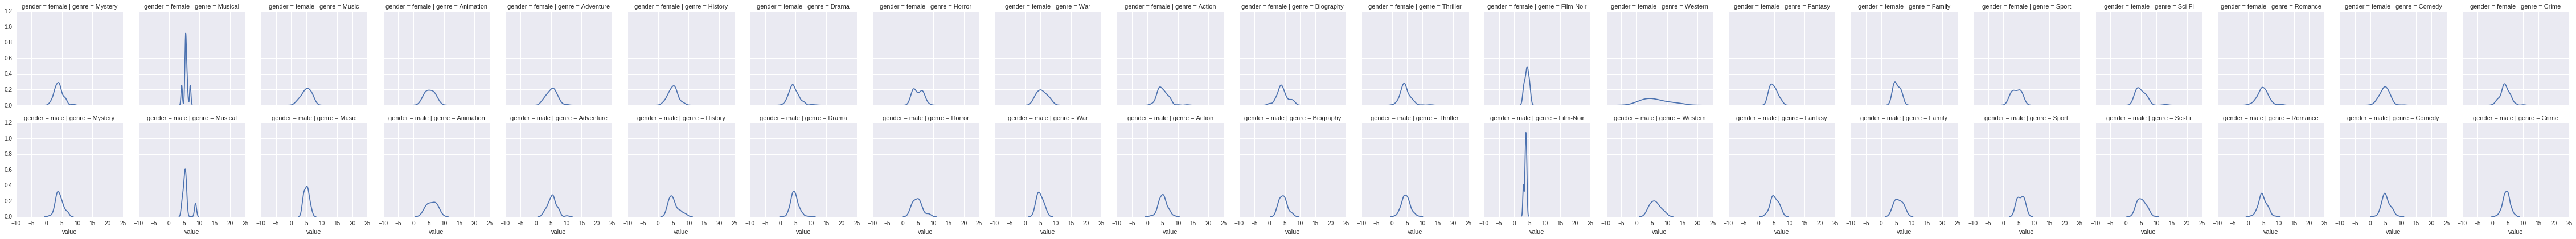

In [56]:
g = sns.FacetGrid(tmp, col = "genre", row = "gender")
g = g.map(sns.distplot, "value", hist=False)

In [57]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg)

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

__There are no significant differences between the degrees based on gender.__

In [58]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[]


# Betweeness Centrality

#### Average centrality

In [59]:
male_cent, female_cent = [], []
for script, d in data.items():
    G = d['graph']
    cents = nx.betweenness_centrality(G)
    
    male_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

Just a quick note, this is a _density_, not a probability. The AUC adds up to 1. 

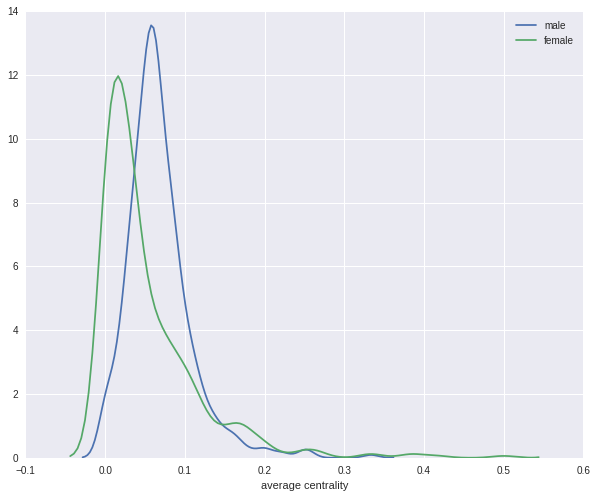

In [60]:
sns.distplot(male_cent, hist = False, label = "male");
sns.distplot(female_cent, hist = False, label = "female");
plt.legend();
plt.xlabel("average centrality");

In this case, there is a significant difference in the average centrality of male characters and female characters ($t(?) = 2.7951,\, p < 0.01$). In most of the scripts, males occupy a more central role than females.

In [61]:
#Remove nans
male_cent, female_cent = np.array(male_cent), np.array(female_cent)
male_cent = male_cent[~np.isnan(male_cent)]
female_cent = female_cent[~np.isnan(female_cent)]


sp.stats.ttest_ind(male_cent, female_cent)

Ttest_indResult(statistic=4.0489751490330361, pvalue=5.5758670778150442e-05)

### Condition on Genre

In [62]:
res = {}
for t in types:
    male_centr, female_centr = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        centralities = nx.betweenness_centrality(G)

        male_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
        female_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))
    
    res[t] = {}
    res[t]['male'] = male_centr
    res[t]['female'] = female_centr

In [63]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "value"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

tmp.head()

,genre,gender,value
0,Mystery,female,0.005291
1,Mystery,female,0.008519
2,Mystery,female,NaN
3,Mystery,female,0.013528
4,Mystery,female,0.030926


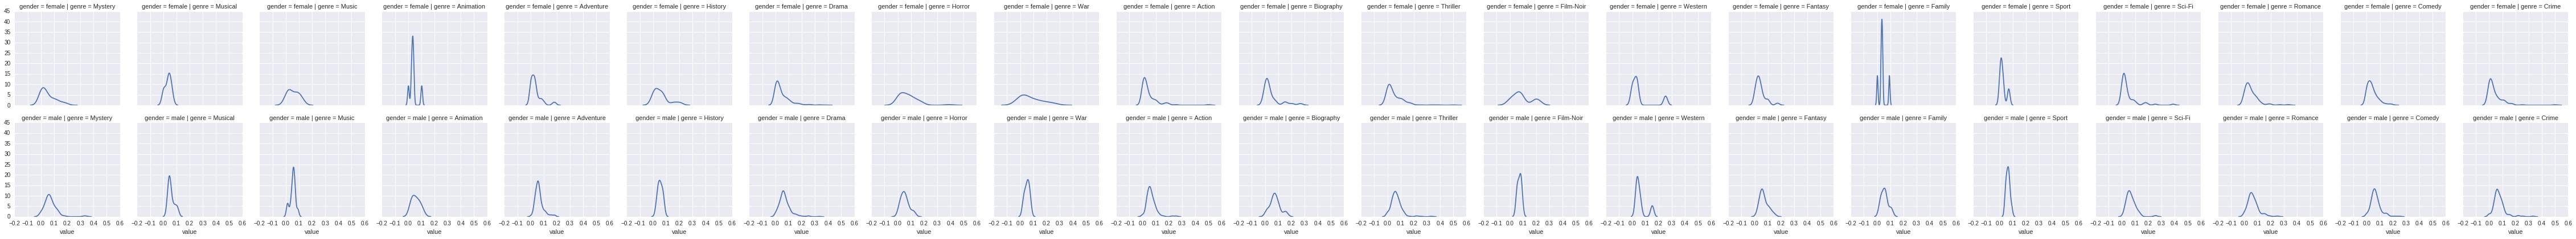

In [64]:
g = sns.FacetGrid(tmp, col = "genre", row = "gender")
g = g.map(sns.distplot, "value", hist=False)

In [65]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg)

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

__ There is a real difference in the centrality of characters in: __

In [66]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[('Comedy',
  Ttest_indResult(statistic=5.646915458081458, pvalue=3.7506478146277182e-08)),
 ('Crime',
  Ttest_indResult(statistic=4.3797581565754928, pvalue=1.7929893821882933e-05)),
 ('Drama',
  Ttest_indResult(statistic=4.1760007662888068, pvalue=3.4745974562051502e-05)),
 ('Adventure',
  Ttest_indResult(statistic=3.5968775559292179, pvalue=0.00048908740405407658)),
 ('Sport',
  Ttest_indResult(statistic=4.2158709640943659, pvalue=0.00051957627257917776)),
 ('Fantasy',
  Ttest_indResult(statistic=2.8186935619720392, pvalue=0.0068472477471550495))]

# Triads and love triangles
Can we say that love triangles are really that common?

In [ ]:
def countTrianglesByGender(G):
    triangles = []

    for i in G.nodes():
        for j in G.neighbors(i):
            if j == i:
                continue 

            for k in G.neighbors(j):
                if k == j or k == i:
                    continue

                if i in G.neighbors(k):
                    triangles.append(tuple(sorted([i, j, k])))

    triangles = set(triangles)
    triangles_genders = map(lambda x: map(lambda _: G.node[_]['gender'], x), triangles)
    
    return Counter(list(map(lambda x: tuple(sorted(list(x))), triangles_genders)))

__Same gender triangles are the least common!!__

In [ ]:
genderTriangs = sum(map(countTrianglesByGender, [d['graph'] for d in data.values()]), Counter())
genderTriangs

### Based on genre

In [ ]:
typeTriangs = {}
for t in types:
    typeTriangs[t] = sum(map(countTrianglesByGender, [d['graph'] for d in data.values() if t in d['genres']]), Counter())
    
typeTriangs;

In [ ]:
typeTriangs_df = []
for t in types:
    for k in typeTriangs[t]:
        typeTriangs_df.append((t, k, typeTriangs[t][k]))
typeTriangs_df = pd.DataFrame(typeTriangs_df, columns = ["genre", "type", "value"])
typeTriangs_df.head()

In [ ]:
#Drop unknown
typeTriangs_df = typeTriangs_df[~np.array(['unknown' in t for t in typeTriangs_df.type])]
typeTriangs_df.head()

#Normalize
totals = typeTriangs_df.groupby("genre").agg({'value':'sum'})
df = pd.Series(index = typeTriangs_df.index)
for idx, row in typeTriangs_df.iterrows():
    df[idx] = (typeTriangs_df.ix[idx, 'value'] / totals.ix[typeTriangs_df.ix[idx, 'genre']])

typeTriangs_df['value'] = df    
    
typeTriangs_df.head()

* __ ('male', 'male', 'male') is the most popular in western and sports movies __
* __ ('female', 'female', 'female') do not appear that much. Mostly on Comedy and Romance __

In [ ]:
g = sns.factorplot("type", "value", hue="genre", data = typeTriangs_df, kind = "bar", aspect = 3, palette=xkcd_colors);
g.set_xticklabels(rotation=90);

## Communities and Modularities

Extract the community structure and modularity measurement of each graph using Louvain Method. The Louvain Method was created by Blondel et. al [https://arxiv.org/abs/0803.0476]

In [67]:
communities = []
modularities = []

for t in types:
    for script, d in data.items():
        if t not in d['genres']:
            continue
        
        G = d['graph']
        parts = community.best_partition(G)
        q = community.modularity(parts, G)
        
        communities.append((t, len(set(parts.values()))))
        modularities.append((t, q))
        
communities = pd.DataFrame(communities, columns=["genre", "communities"])
modularities = pd.DataFrame(modularities, columns=["genre", "modularity"])

In [68]:
communities.communities.describe()

count    1577.000000
mean        2.655041
std         0.873446
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         6.000000
Name: communities, dtype: float64

In [69]:
communities.groupby("genre").apply(np.mean).sort_values(by="communities")

,communities
genre,
Horror,2.392157
Mystery,2.421687
Sci-Fi,2.470588
Thriller,2.525000
Romance,2.568966
Fantasy,2.575000
Musical,2.600000
Crime,2.605442
Western,2.625000


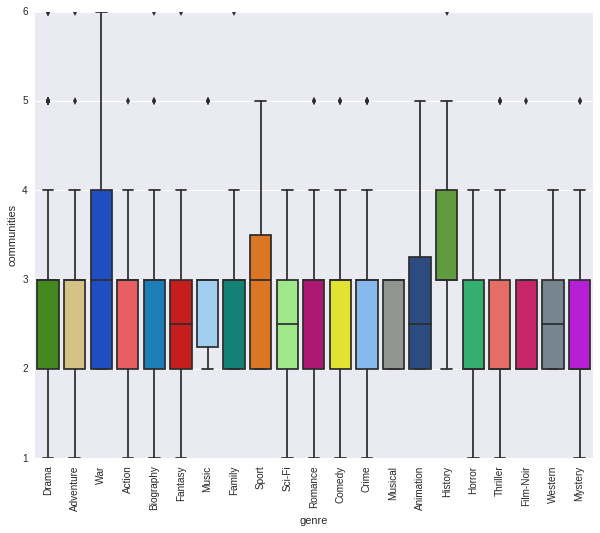

In [70]:
axs = sns.boxplot(x = "genre", y = "communities", data = communities, palette=xkcd_colors)
for item in axs.get_xticklabels():
    item.set_rotation(90)

In [71]:
modularities.modularity.describe()

count    1577.000000
mean        0.157591
std         0.093693
min         0.000000
25%         0.093750
50%         0.154147
75%         0.216696
max         0.546826
Name: modularity, dtype: float64

In [72]:
modularities.groupby("genre").apply(np.mean).sort_values(by="modularity")

,modularity
genre,
Horror,0.132679
Thriller,0.141883
Mystery,0.143064
Sci-Fi,0.143538
Romance,0.145317
Crime,0.151835
Fantasy,0.154817
Comedy,0.157007
Music,0.159065


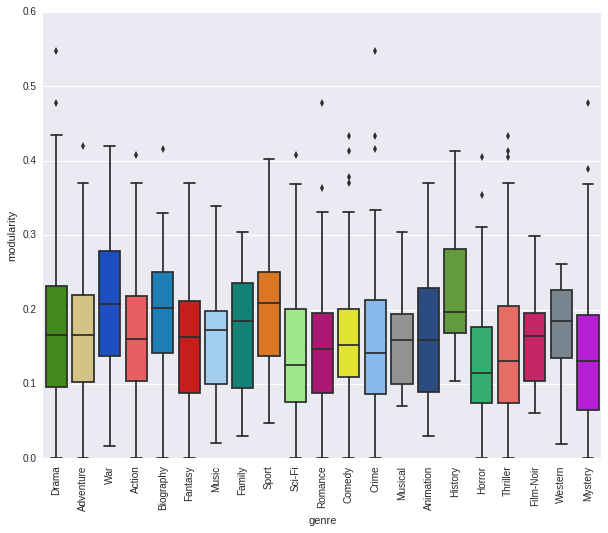

In [73]:
axs = sns.boxplot(x = "genre", y = "modularity", data = modularities, palette=xkcd_colors)
for item in axs.get_xticklabels():
    item.set_rotation(90)

## Can modularity predict genre?
The baselines are already incredibly high, so might not be much point in doing this.

In [199]:
tmp = []
for t in types:
    pos = modularities[modularities.genre == t]
    neg = modularities[modularities.genre != t]
    
    base_score = 100*np.max([len(pos) / (len(pos) + len(neg)), len(neg) / (len(pos) + len(neg))])
    
    # Baseline is most popular class in genre
    print ("{} baseline: {:.2f}%".format(t, base_score))
    
    tmp.append(base_score)
    
np.mean(tmp), np.std(tmp)

Drama baseline: 78.25%
Adventure baseline: 95.50%
War baseline: 98.80%
Action baseline: 92.33%
Biography baseline: 97.59%
Fantasy baseline: 97.46%
Music baseline: 98.86%
Family baseline: 99.43%
Sport baseline: 99.05%
Sci-Fi baseline: 95.69%
Romance baseline: 92.64%
Comedy baseline: 88.08%
Crime baseline: 90.68%
Musical baseline: 99.37%
Animation baseline: 99.49%
History baseline: 98.80%
Horror baseline: 96.77%
Thriller baseline: 87.32%
Film-Noir baseline: 99.68%
Western baseline: 99.49%
Mystery baseline: 94.74%


(95.238095238095255, 5.3248042878938691)

Mayyyybeeeee for drama...

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

for t in types:
    pos = modularities[modularities.genre == t].copy()
    neg = modularities[modularities.genre != t].copy()

    pos['genre_drama'] = 1
    neg['genre_drama'] = 0


    drama_data = pd.concat([pos, neg])
    
    

    X = drama_data.modularity
    X = X.reshape(X.shape[0], 1)

    Y = drama_data.genre_drama

    print("{} model: {:.2f}%".format(t, 100 * cross_val_score(LogisticRegression(), X, Y, cv = 10).mean()))

Drama model: 78.25%
Adventure model: 95.50%
War model: 98.80%
Action model: 92.33%
Biography model: 97.59%
Fantasy model: 97.46%
Music model: 98.86%
Family model: 99.43%
Sport model: 99.05%
Sci-Fi model: 95.69%
Romance model: 92.65%
Comedy model: 88.08%
Crime model: 90.68%
Musical model: 99.37%
Animation model: 99.49%
History model: 98.80%
Horror model: 96.77%
Thriller model: 87.32%
Film-Noir model: 99.68%
Western model: 99.49%
Mystery model: 94.74%
